In [1]:
#loading libraries

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,max_error,mean_absolute_error
import arch

In [2]:
#setting time range

start = '2010-06-07'
end = '2023-02-27'


In [3]:
#downloading data

everything = yf.download('CL=F NG=F GOLD CORN X EURUSD=X ^GSPC', start = start,
                   end = end, interval='1wk', group_by='tickers').reset_index()

everything.head()


[*********************100%***********************]  7 of 7 completed


Date       CORN                                                      \
                   Open       High        Low      Close  Adj Close  Volume   
0 2010-06-07  25.120001  25.879999  25.120001  25.790001  25.790001    2400   
1 2010-06-14  25.990000  26.600000  25.820000  26.389999  26.389999   16300   
2 2010-06-21  26.350000  26.350000  24.889999  24.889999  24.889999   59600   
3 2010-06-28  24.610001  26.580000  23.980000  26.389999  26.389999   74600   
4 2010-07-05  26.270000  27.200001  25.450001  27.110001  27.110001  188400   

           X                        ...       CL=F                        \
        Open       High        Low  ...        Low      Close  Adj Close   
0  42.130001  44.840000  40.099998  ...  69.510002  73.779999  73.779999   
1  46.169998  46.259998  43.000000  ...  74.040001  77.180000  77.180000   
2  45.000000  46.250000  41.490002  ...  75.169998  78.860001  78.860001   
3  43.320000  43.369999  36.930000  ...  71.620003  72.139999  72.139999   
4  39.180000  43.380001  37.700001  ...  71.089996  76.089996  76.089996   

            EURUSD=X                                                 
    Volume      Open      High       Low     Close Adj Close Volume  
0  2128036  1.194415  1.215200  1.188199  1.214285  1.214285      0  
1  1414040  1.214727  1.246588  1.214727  1.241403  1.241403      0  
2  1351679  1.240895  1.246805  1.221076  1.238007  1.238007      0  
3  1565576  1.238007  1.261002  1.215436  1.256108  1.256108      0  
4  1210087  1.255524  1.272103  1.248377  1.264606  1.264606      0  

[5 rows x 43 columns]

In [4]:
list_of_tickers = ['CL=F', 'NG=F', 'GOLD', 'CORN', 'X', 'EURUSD=X', '^GSPC']

variables = pd.DataFrame()
variables['Date'] = everything['Date']

for i in list_of_tickers:
    variables[i] = everything[i]['Close']

variables.rename(columns={'CL=F':'Oil', 'NG=F':'Natgas', 'X':'Steelstock', 'EURUSD=X':'EURUSD','^GSPC':'SP500', 'GOLD':'Gold', 'CORN':'Corn'}, inplace=True)

variables.head()

,Date,Oil,Natgas,Gold,Corn,Steelstock,EURUSD,SP500
0,2010-06-07,73.779999,4.781,43.110001,25.790001,44.820000,1.214285,1091.599976
1,2010-06-14,77.180000,4.997,46.380001,26.389999,43.410000,1.241403,1117.510010
2,2010-06-21,78.860001,4.861,46.330002,24.889999,43.240002,1.238007,1076.760010
3,2010-06-28,72.139999,4.687,43.240002,26.389999,37.660000,1.256108,1022.580017
4,2010-07-05,76.089996,4.402,43.570000,27.110001,42.880001,1.264606,1077.959961


In [5]:
#setting variables

oil_delayed = np.log(variables['Oil'].shift(11)).drop(range(23))

natgas_delayed = np.log(variables['Natgas'].shift(1)).drop(range(23))

gold_delayed = np.log(variables['Gold'].shift(2)).drop(range(23))

steel_delayed = np.log(variables['Steelstock'].shift(1)).drop(range(23))

EURUSD_delayed = np.log(variables['EURUSD'].shift(23)).drop(range(23))

corn_delayed = np.log(variables['Corn'].shift(16)).drop(range(23))

y = np.log(variables['SP500'])

X = pd.concat([oil_delayed,natgas_delayed,gold_delayed,steel_delayed,EURUSD_delayed,corn_delayed],
              axis=1,join='outer').reset_index(drop=True)

y.drop(range(23), inplace=True)
y.reset_index(drop=True, inplace=True)



I decided to use given delays, because its p-values were the lowest. <br><br>
Moreover natural logarithms were used to make time series more smooth.

In [6]:
#splitting into train and test set

periods_to_forecast = 10

y_train = y[:len(y)-periods_to_forecast]

y_test = y[len(y)-periods_to_forecast:]

X_train = X[:len(X)-periods_to_forecast]

X_test = X[len(X)-periods_to_forecast:]


In [7]:
#Checking if differencing is needed in ARIMA model

print('Augmented Dickey-Fuller test p-value for not differenced data: ',
      adfuller(y_train)[1])
print('\nAugmented Dickey-Fuller test p-value for first order differentiation: ',
      adfuller(y_train.diff().dropna())[1])

Augmented Dickey-Fuller test p-value for not differenced data:  0.696486300400568

Augmented Dickey-Fuller test p-value for first order differentiation:  0.0


The null hypothesis: there is a unit root in an AR model <br><br>
First test below implies that the data series is not stationary, so the test should be done one more time in differenced data.<br><br>
Second test implies that differenced data series is stationary, so 'I' parameter for ARIMA model should equal 1.

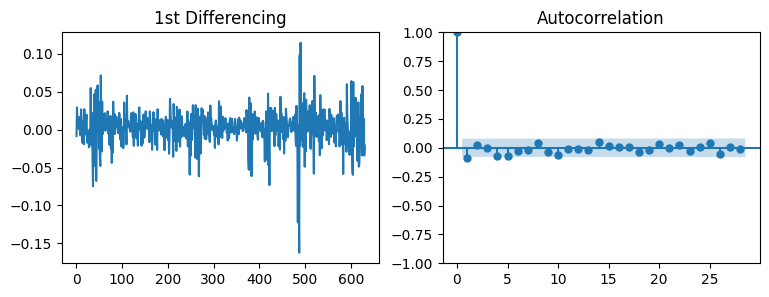

In [8]:
#Autocorrelation plot of differenced series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_train.diff().dropna(), ax=axes[1])
plt.show()

To prevent autocorrelation in my ARIMA model I drew ACF plot.<br><br> 
From the plot above (autocorrelation plot) I choose particural AR parameters: 1,4,5,10 (I consider only AR<=10).

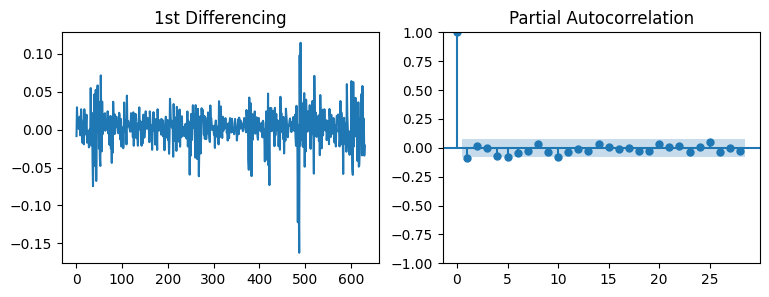

In [9]:
#Partial autocorrelation plot

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_train.diff().dropna(), ax=axes[1], method='ywm')
plt.show()

Then I plotted Partial Autocorrelation to check if any MA parameter should be added to my ARIMA model. <br><br>
The best solution is not to add any MA parameter, but it's also worth check MA=1 (it produces worse results than MA=0).

In [10]:
#setting parameters for ARIMA model

p,d,q = [1,4,5,10], 1, 0

#buiilding ARIMA model

sarimax_model = SARIMAX(endog=y_train, exog=X_train, order=(p,d,q))

model = sarimax_model.fit(maxiter=200)

print(model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            SP500   No. Observations:                  631
Model:             SARIMAX([1, 4, 5, 10], 1, 0)   Log Likelihood                1496.415
Date:                          Thu, 16 Mar 2023   AIC                          -2970.830
Time:                                  16:37:33   BIC                          -2921.927
Sample:                                       0   HQIC                         -2951.835
                                          - 631                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Oil           -0.0371      0.016     -2.382      0.017      -0.068      -0.007
Natgas        -0.0311      0.012     -2.632      0.

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The summary above implies that rising prices of energy and transport (oil and gas) and rising prices of gold and corn should cause that the price of S&P500 index will be lower(for example 1% oil price growth (delayed by 11 weeks) leads to lower index price by 0.0382%).<br><br>
From the other hand, rising value of dollar and steel (both of course delayed) leads to S&P500 index price growth. <br><br>
Presented coefficients seem to be logical, because their signs are the same as I expected before building ARIMA model.

In [11]:
#Statistical tests for this model

print('Autocorrelation p-values for delays from 1 to 14:\n',
      model.test_serial_correlation(method='ljungbox',lags=range(14))[0][1][:],'\n')

print('Normality test p-value: ',
      model.test_normality(method='jarquebera')[0][1],'\n')

print('Heteroskedasticity test p-value: ',
      model.test_heteroskedasticity(method='breakvar')[0][1],'\n')



Autocorrelation p-values for delays from 1 to 14:
 [       nan 0.72755149 0.83626331 0.93729527 0.97327721 0.97313352
 0.59877461 0.67928063 0.76353473 0.66760099 0.75257746 0.80767335
 0.85921095 0.90314153] 

Normality test p-value:  2.879252489191138e-298 

Heteroskedasticity test p-value:  9.893395384707743e-10 



From above statistics tests it should be noticed that there is no problem of autocorrelation, but main problem of presented model is heteroskedasticity.<br> If it comes to normality test, the model's distribution is not normal distribution, but it's not a problem as it has over 600 observations. <br><br>
Only problem, that should be solved is heteroskedasticity problem, because it can make model's predictions less accurate.<br>
However this problem occurs, I decided to check the model's quality predictions.


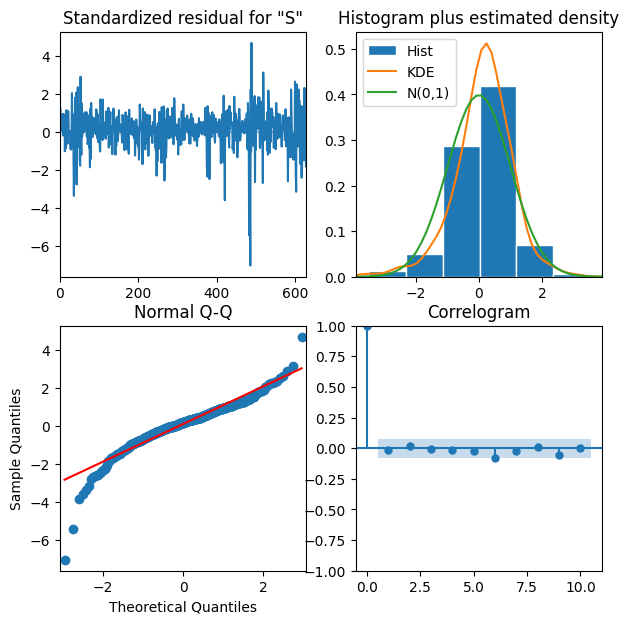

In [12]:
#Visualization

model.plot_diagnostics(figsize=(7,7))
plt.show()

Upper left diagram indices that there is undoubtly heteroskedasticity problem.<br><br>
Upper right diagram shows that there is a difference between model's distribution and normal distribution. <br><br>
Lower left: As all blue dots are not close to red line, the distribution is skewed (but it also can be seen in upper right plot).<br><br>
Lower right plot implies there is no autocorrelation problem.

In [13]:
#Predicting

forecast = pd.DataFrame(model.forecast(steps=periods_to_forecast, exog=X_test))

#First prediction is outlier so I dropped it
prediction = pd.DataFrame(model.predict(n_periods=len(X_train), X=X_train)).drop(0)

forecast_prediction = pd.concat([prediction,forecast],
              axis=0,join='inner')

#Confidence interval (significance level is set to 0.1)

conf_int = model.get_forecast(steps=periods_to_forecast, exog=X_test, alpha=0.1).conf_int()


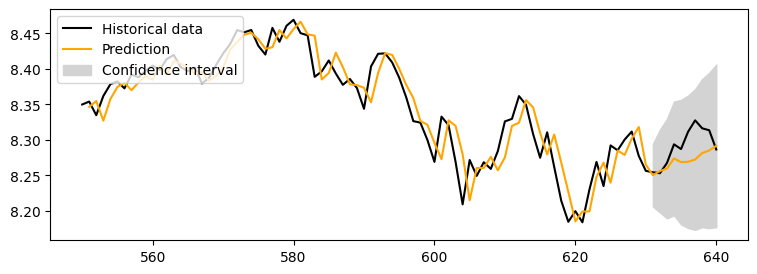

In [14]:
#Plotting predictions

plt.plot(y[550:], label='Historical data', color='black')
plt.plot(forecast_prediction[550:], label='Prediction', color='orange')
plt.fill_between(conf_int.index,conf_int['lower SP500'],conf_int['upper SP500'],
                 color='lightgray', label='Confidence interval')
plt.legend(loc='upper left')
plt.show()

The plot above presents predictions, historical data and confidence interval. <br>
Model's predictions seem to be delayed, but it reflects the trend.

In [15]:
#Evaluating prediction's quality

print('Max error: ', max_error(y_test, forecast))
print('MAE: ',mean_absolute_error(y_test, forecast))
print('MAPE: ',mean_absolute_percentage_error(y_test, forecast))
print('MSE: ',mean_squared_error(y_test, forecast))


Max error:  0.055131498506796106
MAE:  0.02193432634884136
MAPE:  0.002639868677707882
MSE:  0.000770714352129139


Particular errors from this model seems to be quite low (note that for all the values natural logarithm have been used). <br><br>
The main problem is heteroskedasticity so I decided to use GARCH model to do volatility modelling.

In [16]:
#first residual is outlier, so I decided to drop it
arima_residuals = model.resid.drop(0)

#to build GARCH I used residuals multiplied by 1000, because arch module in python suggest using 'higher' values to perform better (it will be then divided by 1000, so this action doesn't affect on results) 

arima_residuals_multby1000 = arima_residuals.apply(lambda x: x*1000) 

garch = arch.arch_model(arima_residuals_multby1000, p=3, q=0, o=0)

garch_fitted = garch.fit(update_freq=5)

garch_fitted.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: 2804.7203739576294
Iteration:     10,   Func. Count:     68,   Neg. LLF: 2771.4978920075105
Iteration:     15,   Func. Count:     98,   Neg. LLF: 2766.8467971321334
Iteration:     20,   Func. Count:    128,   Neg. LLF: 2763.889535017353
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2763.889431507361
            Iterations: 23
            Function evaluations: 145
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2763.89
Distribution:                  Normal   AIC:                           5537.78
Method:            Maximum Likelihood   BIC:                           5560.01
                                        No. Observations:                  630
Date:                Thu, Mar 16 2023   Df Residuals:                      629
Time:                        16:37:34   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.2248      0.672      6.286  3.255e-10 [  2.908,  5.542]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        144.1529     26.007      5.543  2.974e-08 [ 93.181,1.951e+02]
alpha[1]       0.2557  7.658e-02      3.339  8.394e-04   [  0.106,  0.406]
alpha[2]       0.2343  9.085e-02      2.579  9.915e-03 [5.622e-02,  0.412]
alpha[3]       0.3226      0.130      2.480  1.315e-02 [6.762e-02,  0.578]
==========================================================================

Covariance estimator: robust
"""

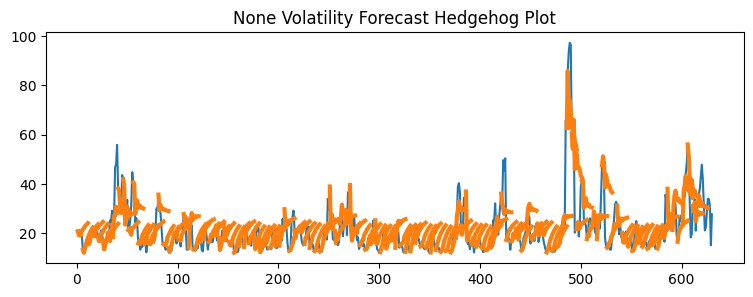

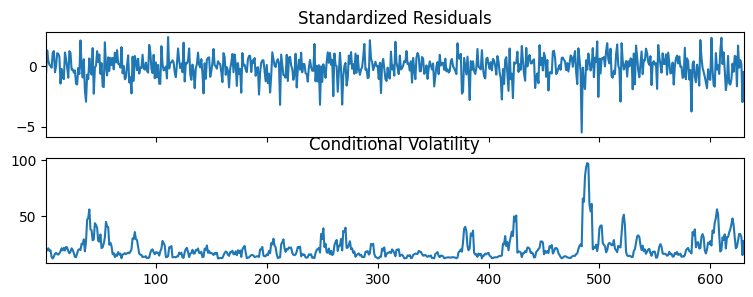

In [17]:
garch_fitted.hedgehog_plot(step=5)
plt.show()
garch_fitted.plot()
plt.show()

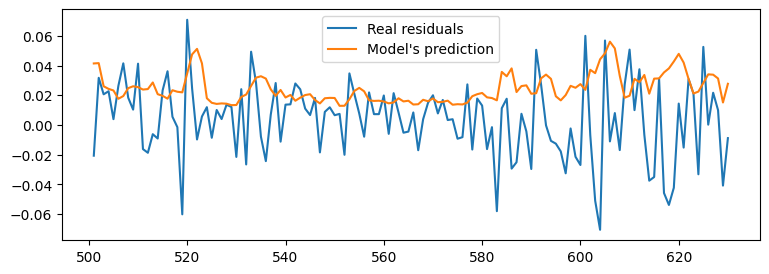

In [18]:
garch_forecast = garch_fitted.forecast(horizon=periods_to_forecast, reindex=True)
cor_indx = list(range(len(y)-periods_to_forecast,len(y)))
forecasted_mean = garch_forecast.mean.iloc[-1].rename('predicted_mean', inplace=True).apply(lambda x: x/1000).to_frame()
forecasted_mean['Indx'] = cor_indx
forecasted_mean.set_index('Indx', drop=True, inplace=True)
predicted_cond_vol = pd.Series(garch_fitted.conditional_volatility).apply(lambda x: x/1000).rename('predicted_mean', inplace=True).to_frame()
plt.plot(arima_residuals[500:], label='Real residuals')
plt.plot(predicted_cond_vol[500:], label='Model\'s prediction')
plt.legend()
plt.show()

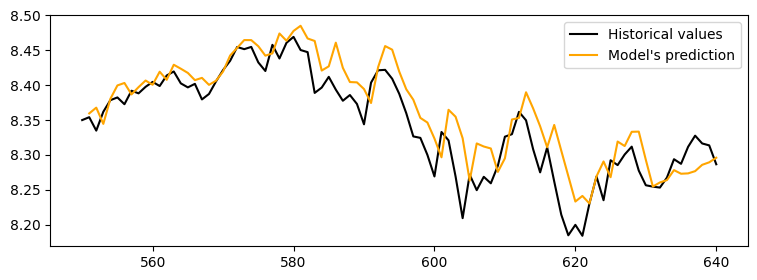

In [19]:
final_forecast = forecast + forecasted_mean
final_prediction = prediction + predicted_cond_vol
final_forecast_prediction = pd.concat([final_prediction, final_forecast], axis=0, join='inner')
plt.plot(y[550:], label='Historical values', color='black')
plt.plot(final_forecast_prediction[550:], label='Model\'s prediction', color='orange')
plt.legend()
plt.show()

In [20]:

print('ARIMA particular errors:')
print('Max error: ', max_error(y_test, forecast))
print('MAE: ',mean_absolute_error(y_test, forecast))
print('MAPE: ',mean_absolute_percentage_error(y_test, forecast))
print('MSE: ',mean_squared_error(y_test, forecast),'\n\n')

print('ARIMA-GARCH errors:')
print('Max error: ', max_error(y_test, final_forecast))
print('MAE: ',mean_absolute_error(y_test, final_forecast))
print('MAPE: ',mean_absolute_percentage_error(y_test, final_forecast))
print('MSE: ',mean_squared_error(y_test, final_forecast))

ARIMA particular errors:
Max error:  0.055131498506796106
MAE:  0.02193432634884136
MAPE:  0.002639868677707882
MSE:  0.000770714352129139 


ARIMA-GARCH errors:
Max error:  0.05090671140948011
MAE:  0.019424491551183996
MAPE:  0.002337693199186505
MSE:  0.0006172533079431581


In [21]:
print('Max error change: ', max_error(y_test,final_forecast)*100/max_error(y_test,forecast) - 100, '%')
print('MAE change: ', mean_absolute_error(y_test,final_forecast)*100/mean_absolute_error(y_test,forecast) - 100, '%')
print('MAPE change: ', mean_absolute_percentage_error(y_test,final_forecast)*100/mean_absolute_percentage_error(y_test,forecast) - 100, '%')
print('MSE change: ', mean_squared_error(y_test,final_forecast)*100/mean_squared_error(y_test,forecast) - 100, '%')

Max error change:  -7.663109495917666 %
MAE change:  -11.442497744134926 %
MAPE change:  -11.446610245163669 %
MSE change:  -19.911533210979755 %


In percentage terms adding GARCH component improved model's predictions (because errors are lower).<br><br> 
It's better, so I decided to check ex-ante forecast.

In [22]:
sp500_ex_ante = yf.download('^GSPC', start = '2023-03-05',
                   end = '2023-03-7', interval='1wk')['Adj Close'].rename('SP500', inplace=True).reset_index(drop=True)

oil_ex_ante = yf.download('CL=F', start = '2022-12-19',
                   end = '2022-12-20', interval='1wk')['Adj Close'].rename('Oil', inplace=True).reset_index(drop=True)

natgas_ex_ante = yf.download('NG=F', start = '2023-02-26',
                   end = '2023-02-28', interval='1wk')['Adj Close'].rename('Natgas', inplace=True).reset_index(drop=True)

gold_ex_ante = yf.download('GOLD', start = '2023-02-20',
                   end = '2023-02-21', interval='1wk')['Adj Close'].rename('Gold', inplace=True).reset_index(drop=True)


corn_ex_ante = yf.download('CORN', start = '2022-11-14',
                   end = '2022-11-15', interval='1wk')['Adj Close'].rename('Corn', inplace=True).reset_index(drop=True)

steelStock_ex_ante = yf.download('X', start = '2023-02-26',
                   end = '2023-02-28', interval='1wk')['Adj Close'].rename('Steelstock', inplace=True).reset_index(drop=True)

EURUSD_ex_ante = yf.download('EURUSD=X', start = '2022-09-26',
                   end = '2022-09-27', interval='1wk')['Adj Close'].rename('EURUSD', inplace=True).reset_index(drop=True)

X_ex_ante = np.log(pd.concat([oil_ex_ante, natgas_ex_ante, gold_ex_ante, steelStock_ex_ante, EURUSD_ex_ante, corn_ex_ante], axis=1, join='outer').reset_index(drop=True))
X_ex_ante.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Oil,Natgas,Gold,Steelstock,EURUSD,Corn
0,4.331917,1.010509,2.802531,3.42198,-0.038355,3.282038


I download data from given periods which corresponds to shifts I used before to train ARIMA model.

In [23]:
def forecast_ex_ante_value(X):
    ex_ante_ARIMA_forecast = model.forecast(steps=1, exog=X_ex_ante)
    ex_ante_garch_forecast = garch_fitted.forecast(horizon=1, reindex=True)
    ex_ante_forecasted_garch = ex_ante_garch_forecast.mean.iloc[-1].rename('predicted_mean', inplace=True).apply(lambda x: x/1000).to_frame()
    return np.exp(ex_ante_ARIMA_forecast.values + ex_ante_forecasted_garch.values)

print('Forecasted S&P500 close price: ', forecast_ex_ante_value(X_ex_ante)[0])
print('Real S&P500 close price: ', sp500_ex_ante[0])
print('Mean absolute percentage error: ', mean_absolute_percentage_error(forecast_ex_ante_value(X_ex_ante), sp500_ex_ante))

Forecasted S&P500 close price:  [3977.41630538]
Real S&P500 close price:  3986.3701171875
Mean absolute percentage error:  0.002251162845700623


Ex ante forecast works as expected. <br>
Error is quite low as it's about 0.23%, so this result is quite good and it's value is very similar to values from ex-post forecast. <br>
Unfortunately minimum delay of exogenous variables is 1, so I can do only 1 ex-ante forecast at the time. 